In [1]:
import os
import os.path as op
import sys

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

#from bluemath_tk.wrappers.swash.swash_wrapper import SwashModelWrapper
from IPython.display import HTML

from scripts.wrappers import SwashModelWrapper_friction

from scripts.bathymetry import reef_profile
from scripts.plots import plot_case_config

## 01.Define Case Variables

#### Necessary Paths

In [2]:
templates_dir = '/workspaces/ONDAS_Swash/templates/templates_friction'
output_dir = '/workspaces/ONDAS_Swash/cases/friction'

#### Hydrodynamic Forcing

In [3]:
Hs = 2.5
Tp = 10
Hs_L0 =  round((2 * np.pi * (Hs)) / (9.81 * (Tp ** 2)),4)  # Should be between 0.005 and 0.05
WL = 0.0

In [4]:
Hs_L0

0.016

In [5]:
dx = 1

h0 = 15                     # offshore depth (m)
Slope1 = 0.05               # fore shore slope
Slope2 = 0.1                # inner shore slope
Wreef = 200                 # reef bed width (m)
Wfore = 500                 # flume length before fore toe (m)
bCrest = 10                 # beach heigh (m)
emsl = 2.5                  # mean sea level (m)

x_profile, depth_array = reef_profile(dx, h0, Slope1, Slope2, Wreef, Wfore, bCrest, emsl)

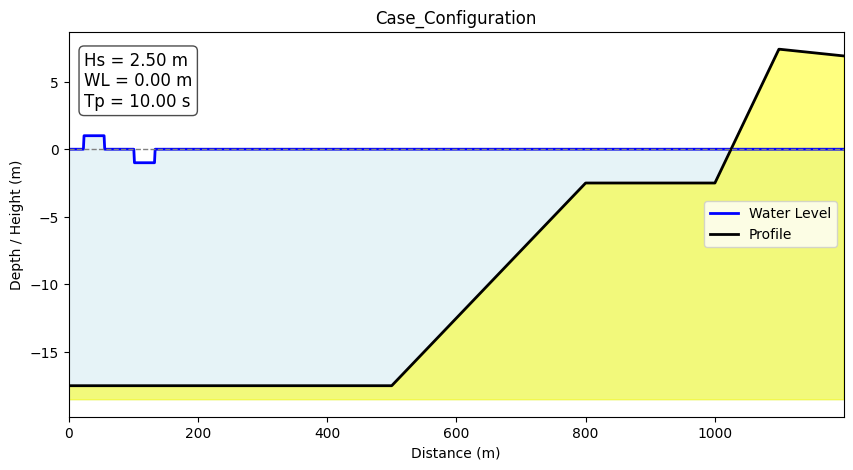

In [6]:
plot_case_config(x=x_profile, z=depth_array, wave_height=Hs, wave_period = Tp, WL=WL)

In [7]:
params = pd.DataFrame()
params['friction_coef'] = np.round(np.arange(0.1,0.35,0.05),3) # Vector de 8 a 20 de 1 en 1

params['Hs'] = Hs
params['Hs_L0'] = Hs_L0 
params['WL'] = WL

params['pos_ini'] = 800
params['pos_fin'] = 1000

In [8]:
params

,friction_coef,Hs,Hs_L0,WL,pos_ini,pos_fin
0,0.10,2.5,0.016,0.0,800,1000
1,0.15,2.5,0.016,0.0,800,1000
2,0.20,2.5,0.016,0.0,800,1000
3,0.25,2.5,0.016,0.0,800,1000
4,0.30,2.5,0.016,0.0,800,1000


In [9]:
metamodel_parameters = params.to_dict(orient='list')
fixed_parameters = {
    "dxinp": 1,  # bathymetry grid spacing  # Friction manning coefficient (m^-1/3 s)
    "comptime": 1600,  # Simulation duration (s)
    "warmup": 300,  # Warmup duration (s)
    "n_nodes_per_wavelength": 60,  # number of nodes per wavelength
}

swash_model = SwashModelWrapper_friction(
    templates_dir=templates_dir,
    metamodel_parameters=metamodel_parameters,
    fixed_parameters=fixed_parameters,
    output_dir=output_dir,
    depth_array=-depth_array,
)

2025-11-17 15:19:43,848 - SwashModelWrapper_friction - WARNING - Parameter friction_coef is not in the default_parameters
2025-11-17 15:19:43,855 - SwashModelWrapper_friction - WARNING - Parameter pos_ini is not in the default_parameters
2025-11-17 15:19:43,859 - SwashModelWrapper_friction - WARNING - Parameter pos_fin is not in the default_parameters


In [10]:
swash_model.build_cases()

In [11]:
swash_model.run_cases(launcher='serial')

In [12]:
vars_to_postprocess = ["Msetup", "Hrms", "Hfreqs" , "Ru2"]
postprocessed = swash_model.postprocess_cases(output_vars=vars_to_postprocess)

In [13]:
postprocessed

<xarray.Dataset> Size: 298kB
Dimensions:   (case_num: 5, Xp: 1200)
Coordinates:
  * case_num  (case_num) int64 40B 0 1 2 3 4
  * Xp        (Xp) int64 10kB 0 1 2 3 4 5 6 ... 1194 1195 1196 1197 1198 1199
    Yp        int64 8B 0
Data variables:
    Msetup    (case_num, Xp) float64 48kB 0.01735 0.0147 0.01162 ... 6.91 6.906
    Hrms      (case_num, Xp) float64 48kB 1.793 1.78 ... 2.512e-15 2.512e-15
    Hs        (case_num, Xp) float64 48kB 2.533 2.516 2.484 ... 0.0 3.243e-15
    Hss       (case_num, Xp) float64 48kB 2.526 2.508 2.476 ... 0.0 1.176e-18
    ig        (case_num, Xp) float64 48kB 0.1939 0.1959 0.2025 ... 0.0 3.243e-15
    Hvlf      (case_num, Xp) float64 48kB 0.04473 0.04493 ... 0.0 3.036e-15
    Ru2       (case_num) float64 40B 1.717 1.265 1.026 0.746 0.6305

In [14]:
params

,friction_coef,Hs,Hs_L0,WL,pos_ini,pos_fin
0,0.10,2.5,0.016,0.0,800,1000
1,0.15,2.5,0.016,0.0,800,1000
2,0.20,2.5,0.016,0.0,800,1000
3,0.25,2.5,0.016,0.0,800,1000
4,0.30,2.5,0.016,0.0,800,1000


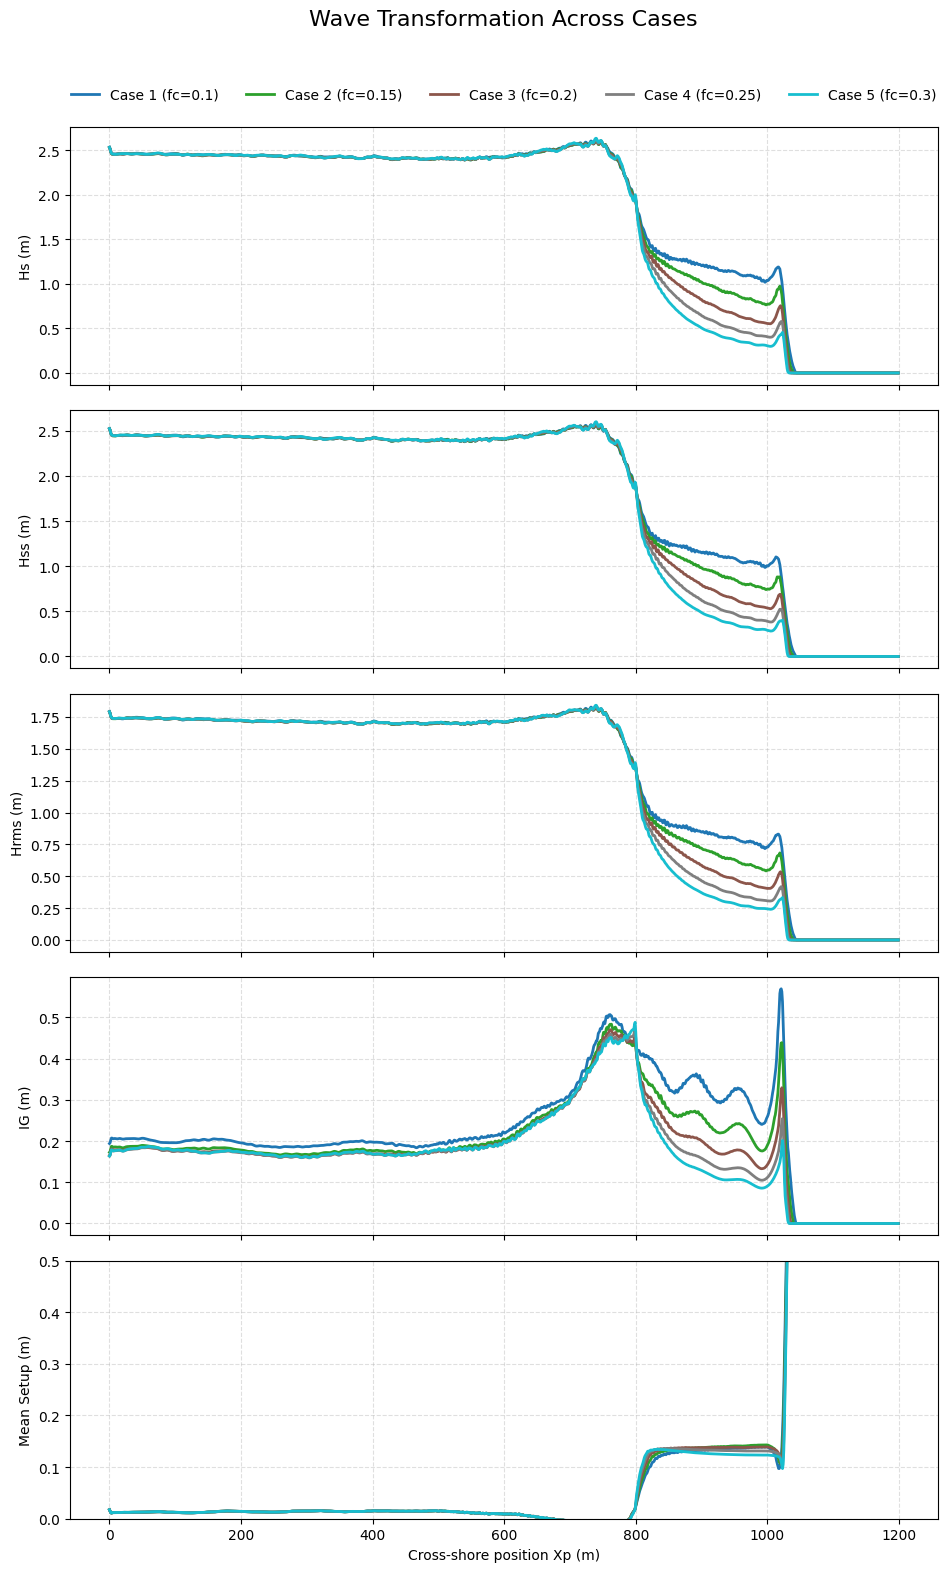

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Number of cases
n_cases = len(postprocessed.case_num.values)

# Assign a unique color per case

if n_cases <= 10:
    cmap = plt.cm.get_cmap("tab10", n_cases)
else:
    cmap = plt.cm.get_cmap("tab20", n_cases)

colors = [cmap(i) for i in range(n_cases)]
# Create figure with 5 subplots (one per variable)
fig, axs = plt.subplots(5, 1, figsize=(10, 16), sharex=True)

ax_Hs, ax_Hss, ax_Hrms, ax_IG, ax_Setup = axs

for i in range(n_cases):
    post_process_case = postprocessed.isel(case_num=i)
    Xp = post_process_case.Xp
    color = colors[i]
    fc = params['friction_coef'][i]

    # --- Hs --------------------------------------------------------
    ax_Hs.plot(Xp, post_process_case.Hs,
               label=f"Case {i+1} (fc={fc})", lw=2, color=color)

    # --- Hss -------------------------------------------------------
    ax_Hss.plot(Xp, post_process_case.Hss,
                label=f"Case {i+1} (fc={fc})", lw=2, color=color)

    # --- Hrms ------------------------------------------------------
    ax_Hrms.plot(Xp, post_process_case.Hrms,
                 label=f"Case {i+1} (fc={fc})", lw=2, color=color)

    # --- IG --------------------------------------------------------
    ax_IG.plot(Xp, post_process_case.ig,
               label=f"Case {i+1} (fc={fc})", lw=2, color=color)

    # --- Mean Setup ------------------------------------------------
    ax_Setup.plot(Xp, post_process_case.Msetup,
                  label=f"Case {i+1} (fc={fc})", lw=2, color=color)


# ---- Axis labels ----------------------------------------------------
ax_Hs.set_ylabel("Hs (m)")
ax_Hss.set_ylabel("Hss (m)")
ax_Hrms.set_ylabel("Hrms (m)")
ax_IG.set_ylabel("IG (m)")
ax_Setup.set_ylabel("Mean Setup (m)")
ax_Setup.set_xlabel("Cross-shore position Xp (m)")
ax_Setup.set_ylim(0,0.5)
# ---- Formatting -----------------------------------------------------
for ax in axs:
    ax.grid(ls="--", alpha=0.4)

# One legend for all panels
ax_Hs.legend(ncol=5, bbox_to_anchor=(0.5, 1.2),
             loc="upper center", frameon=False)

fig.suptitle("Wave Transformation Across Cases", fontsize=16, y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


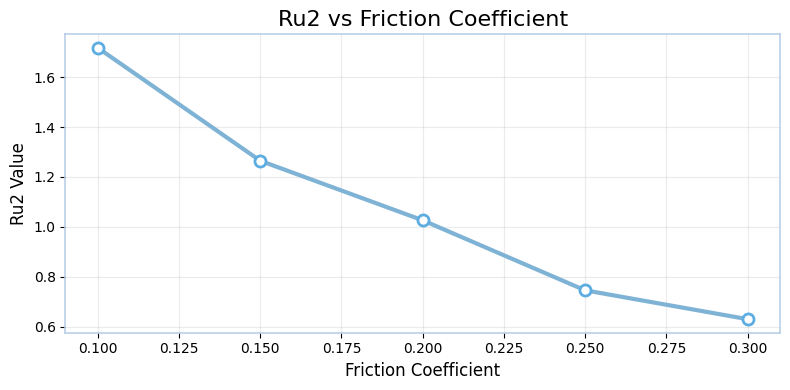

In [19]:
# soft, pleasant colors
line_color = "#7fb3d5"
marker_edge = "#5dade2"

x_vals = params["friction_coef"]
y_vals = postprocessed.Ru2

plt.figure(figsize=(8, 4))

plt.plot(
    x_vals,
    y_vals,
    color=line_color,
    linewidth=3,
    marker="o",
    markersize=8,
    markerfacecolor="white",
    markeredgecolor=marker_edge,
    markeredgewidth=2
)

plt.title("Ru2 vs Friction Coefficient", fontsize=16)
plt.xlabel("Friction Coefficient", fontsize=12)
plt.ylabel("Ru2 Value", fontsize=12)

plt.grid(alpha=0.25)

# soften the spines for a cleaner look
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.1)
    spine.set_color("#b4cbe6")

plt.tight_layout()
plt.show()